In [167]:
# imports

import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pycmap
import seaborn as sns
import warnings

# stop showing SettingWithCopyWarning
pd.options.mode.chained_assignment = None


In [2]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

grays = ['#0F0A0A', '#52525E', '#747688', '#959AB1', '#959AB1', '#CECFD5', '#E0E0E0']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

# div_hexes = ['#7222D3', neutral_color, '#FF780A']
# div_cmap = get_continuous_cmap(div_hexes)


In [3]:
# helper functions

def unique_bins(array, n_bins, bounds=None, reverse=False):
    '''This is a function that maps an array of continuous values with potential duplicates to 
    a set of bins in such a way that each of the original continuous values is mapped to a unique bin, and the
    distribution of binned values approximates the distribution of continuous values as closely as possible.
    
    My quick and dirty approach to this problem sorts the input array into the appropriate number of bins. Then,
    starting in the middle and alternating outward left and right, the algorithm checks to see if each bin has 
    more than one resident. If so, it will again alternate outward left and right from that position and allocate
    the extra residents to the nearest free bins.
    
    Parameters
    ----------
    array : np.array
        Sorted array of values to be placed into bins.
    n_bins : int
        Number of bins to use.
    bounds : (float, float)
        Upper and lower bounds to use for bin-mapping.
    reverse : bool
        Optional flag to reverse the index ordering of the output.
    
        
    Returns
    -------
    index : np.array
        Indices indicating mapping of input values to bins, where index[i] indicates the index of the bin 
        mapping of input value array[i] (assuming input array is sorted).
    '''
    # check number of bins
    if not n_bins >= len(array):
        raise ValueError('The number of bins must be >= len(array).')
    # add bounds if supplied
    if bounds is not None:
        array = np.concatenate((array, bounds))
    # make histogram
    counts, _ = np.histogram(array, bins=n_bins)
    # remove bounds if added
    if bounds is not None:
        counts[0] -= 1
        counts[-1] -= 1
    # start from the middle
    i = int(n_bins/2)
    for j in range(n_bins):
        # alternate left and right
        if j % 2:
            i -= j
        else:
            i += j
        # resolve collisions
        if counts[i] > 1:
            # set new counter for exploring nearby positions
            k = i
            for l in range(2*n_bins):
                # alternate left and right
                if l % 2:
                    k -= l
                else:
                    k += l
                # check if we're still in range
                if 0 <= k < n_bins:
                    # check for an empty spot
                    if counts[k] == 0:
                        counts[k] = 1
                        counts[i] -= 1
                        # check if all collisions have been resolved yet
                        if counts[i] == 1:
                            break
    # select indices of non-zero values
    index = np.where(counts == 1)[0]
    # reverse if requested
    if reverse:
        index = (n_bins - 1) - index
    return index


# import data

In [54]:
# read in sample metadata

sample_df = pd.read_csv(data_path / 'metadata/archive/sample_metadata_merged.csv')

sample_df


,samplename,cruise,year,datetime,latitude,longitude,depth,dataset,samplegroup,timefraction,timeclass,experiment,condition,treatment,timepoint
0,G2.DCM.NS.S11C2.50m,Gradients 2,2017,6/6/17 6:56,36.999833,-158.000,50,Gradients 2 DCM,depth profiles,0.29,6am,NaN,NaN,NaN,NaN
1,G2.DCM.NS.S15C2.56m,Gradients 2,2017,6/9/17 5:30,34.000167,-158.000,56,Gradients 2 DCM,depth profiles,0.23,6am,NaN,NaN,NaN,NaN
2,G2.DCM.NS.S17C3.87m,Gradients 2,2017,6/10/17 9:34,32.000167,-158.000,87,Gradients 2 DCM,depth profiles,0.40,10am,NaN,NaN,NaN,NaN
3,G2.DCM.NS.S18C2.95m,Gradients 2,2017,6/11/17 5:50,29.582000,-158.002,95,Gradients 2 DCM,depth profiles,0.24,6am,NaN,NaN,NaN,NaN
4,G3.DEPTH.NS.S4C6.75m,Gradients 3,2019,4/16/19 8:00,41.670000,-158.050,75,Gradients 3 depth profile,depth profiles,0.33,10am,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,G3.DEPTH.NS.S6C7.15m,Gradients 3,2019,4/22/19 6:44,32.920000,-158.000,15,Gradients 3 depth profile,surface transect,0.28,6am,NaN,NaN,NaN,NaN
83,G3.UW.NS.UW40_1.7m,Gradients 3,2019,4/24/19 5:57,40.880000,-158.000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
84,G3.DEPTH.NS.S8C2.15m,Gradients 3,2019,4/24/19 14:47,42.330000,-158.000,15,Gradients 3 depth profile,surface transect,0.62,2pm,NaN,NaN,NaN,NaN
85,G3.UW.NS.UW40_2.7m,Gradients 3,2019,4/25/19 6:01,40.090000,-158.000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN


In [60]:
# read in abundance and coverage data

data_path = Path('../../data')
abun_df = pd.read_csv(data_path / '2-mapping/aggregate-clade-reads.csv')

# get sample name and replicates
abun_df = pd.merge(abun_df, abun_df['SampleID'].str.rsplit('.', n=1, expand=True), left_index=True, right_index=True).rename(
    columns={0: 'SampleName', 1: 'Replicate'}
)

# add in sample data
abun_df = pd.merge(
    abun_df, sample_df, left_on='SampleName', right_on='samplename', how='left'
)

abun_df


,SampleID,Group,Clade,CladeReads,SampleReads,RelativeAbundance,PangenomeSize,DetectedPangenomeSize,DetectedCyCOGs,PangenomeCoverage,...,longitude,depth,dataset,samplegroup,timefraction,timeclass,experiment,condition,treatment,timepoint
0,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,AMZ-II,507.205,5433304.056,0.000093,1762.0,127.0,0.0,0.000000,...,-157.994333,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
1,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,272443.296,5433304.056,0.050143,4906.0,3906.0,575.0,0.117203,...,-157.994333,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
2,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLII,4828459.042,5433304.056,0.888678,6997.0,4787.0,1740.0,0.248678,...,-157.994333,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
3,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLII.HLVI,34148.879,5433304.056,0.006285,1822.0,1144.0,146.0,0.080132,...,-157.994333,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
4,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLIII,24885.537,5433304.056,0.004580,1652.0,221.0,11.0,0.006659,...,-157.994333,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6655,G3.UW.NS.UW40_2.7m.C,Synechococcus,5.1B-VI,379.143,6469143.806,0.000059,2564.0,226.0,8.0,0.003120,...,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
6656,G3.UW.NS.UW40_2.7m.C,Synechococcus,5.1B-VIII,2009.257,6469143.806,0.000311,2515.0,239.0,3.0,0.001193,...,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
6657,G3.UW.NS.UW40_2.7m.C,Synechococcus,5.2,267334.246,6469143.806,0.041325,5123.0,481.0,13.0,0.002538,...,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
6658,G3.UW.NS.UW40_2.7m.C,Synechococcus,5.3,1016616.381,6469143.806,0.157149,2783.0,526.0,2.0,0.000719,...,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN


# plot pangenome sizes

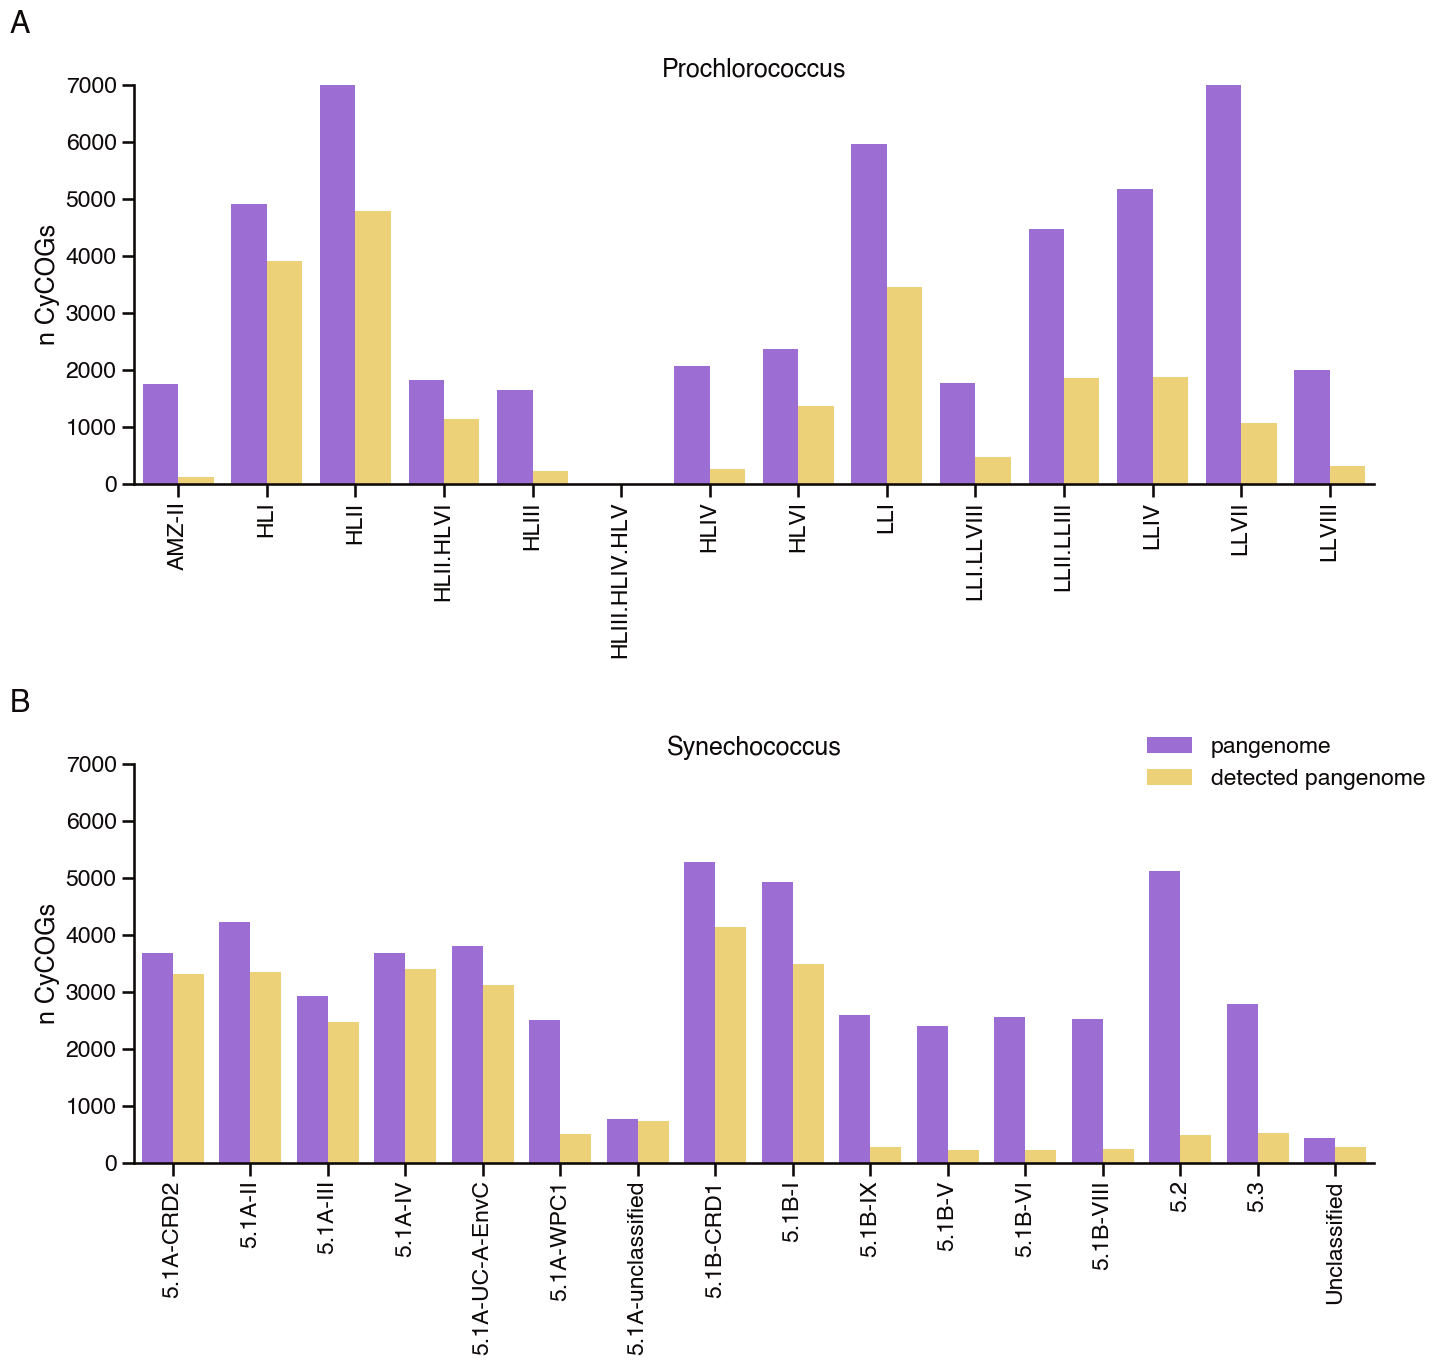

In [146]:
# plot pangenome size by clade

# By means of comparison, in Zinser et al., 2009, they found that 89% of the protein coding genes of MED4 
# (1511/1698) were detectibly expressed at some point over the 24h cycle. https://doi.org/10.1371/journal.pone.0005135

# set up data
data_df = abun_df[['Group', 'Clade', 'PangenomeSize', 'DetectedPangenomeSize']].drop_duplicates()
data_df = data_df.melt(
    id_vars=['Group', 'Clade'], value_vars=['PangenomeSize', 'DetectedPangenomeSize'], var_name='category', value_name='n CyCOGs'
)
data_df['category'] = data_df['category'].map({'PangenomeSize': 'pangenome', 'DetectedPangenomeSize': 'detected pangenome'})

# set up figure
fig = plt.figure(figsize=(16, 14))
grid = plt.GridSpec(2, 1, hspace=.7)
annot_kwgs = {
    'xycoords': 'axes fraction', 'va': 'center', 'ha': 'left', 'fontsize': 22, 'annotation_clip': False
}

# plot data
for i, genus in enumerate(['Prochlorococcus', 'Synechococcus']): 
    # set up subplot
    axis = plt.subplot(grid[i,0])
    axis.annotate({0:'A', 1:'B'}[i], xy=(-0.1, 1.15), **annot_kwgs)
    # set up subplot data
    plot_df = data_df[data_df['Group'] == genus].sort_values('Clade')
    sns.barplot(
        plot_df, x='Clade', y='n CyCOGs', hue='category', palette=[sns.color_palette()[i] for i in [0, 6]], legend=(i==1), ax=axis
    ); 
    # fix axes
    axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=90)
    axis.set(ylim=(0, 7000), xlabel='', title=genus)
    # fix legend
    if i: 
        axis.legend(title='', loc='center left', bbox_to_anchor=(0.8, 1))

# save plot
fig.savefig('detected-pangenomes-by-clade.png', bbox_inches='tight')


# plot aggregate clade reads

In [272]:
# generate aggregate transcript reads per sample by genus

genus_abun_df = abun_df.groupby(['SampleID', 'SampleName', 'Group']).CladeReads.sum().reset_index().rename(
    columns={'CladeReads': 'GenusReads'}
)
genus_abun_df = pd.merge(
    genus_abun_df, sample_df, left_on='SampleName', right_on='samplename', how='left'
)

# # normalize per million reads
# genus_abun_df['GenusReads'] = genus_abun_df['GenusReads'] / 1000000

# separate out Pro & Syn
pro_abun_df = genus_abun_df[genus_abun_df['Group'] == 'Prochlorococcus']
syn_abun_df = genus_abun_df[genus_abun_df['Group'] == 'Synechococcus']

genus_abun_df


,SampleID,SampleName,Group,GenusReads,samplename,cruise,year,datetime,latitude,longitude,depth,dataset,samplegroup,timefraction,timeclass,experiment,condition,treatment,timepoint
0,G1.SURF.NS.S02C1.15m.A,G1.SURF.NS.S02C1.15m,Prochlorococcus,5274526.275,G1.SURF.NS.S02C1.15m,Gradients 1,2016,4/20/16 5:51,23.495833,-157.994333,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
1,G1.SURF.NS.S02C1.15m.A,G1.SURF.NS.S02C1.15m,Synechococcus,158777.781,G1.SURF.NS.S02C1.15m,Gradients 1,2016,4/20/16 5:51,23.495833,-157.994333,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
2,G1.SURF.NS.S02C1.15m.B,G1.SURF.NS.S02C1.15m,Prochlorococcus,8929478.790,G1.SURF.NS.S02C1.15m,Gradients 1,2016,4/20/16 5:51,23.495833,-157.994333,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
3,G1.SURF.NS.S02C1.15m.B,G1.SURF.NS.S02C1.15m,Synechococcus,215674.011,G1.SURF.NS.S02C1.15m,Gradients 1,2016,4/20/16 5:51,23.495833,-157.994333,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
4,G1.SURF.NS.S02C1.15m.C,G1.SURF.NS.S02C1.15m,Prochlorococcus,7431552.844,G1.SURF.NS.S02C1.15m,Gradients 1,2016,4/20/16 5:51,23.495833,-157.994333,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,G3.UW.NS.UW40_2.7m.A,G3.UW.NS.UW40_2.7m,Synechococcus,1800562.929,G3.UW.NS.UW40_2.7m,Gradients 3,2019,4/25/19 6:01,40.090000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
440,G3.UW.NS.UW40_2.7m.B,G3.UW.NS.UW40_2.7m,Prochlorococcus,2831082.362,G3.UW.NS.UW40_2.7m,Gradients 3,2019,4/25/19 6:01,40.090000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
441,G3.UW.NS.UW40_2.7m.B,G3.UW.NS.UW40_2.7m,Synechococcus,1523669.922,G3.UW.NS.UW40_2.7m,Gradients 3,2019,4/25/19 6:01,40.090000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
442,G3.UW.NS.UW40_2.7m.C,G3.UW.NS.UW40_2.7m,Prochlorococcus,4187305.298,G3.UW.NS.UW40_2.7m,Gradients 3,2019,4/25/19 6:01,40.090000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN


In [77]:
# generate compositional dataset

comp_df = pd.merge(abun_df, genus_abun_df[['SampleID', 'Group', 'GenusReads']], on=['SampleID', 'Group'], how='left')
comp_df['CladeProportionReads'] = comp_df['CladeReads'] / comp_df['GenusReads']

comp_df

,SampleID,Group,Clade,CladeReads,SampleReads,RelativeAbundance,PangenomeSize,DetectedPangenomeSize,DetectedCyCOGs,PangenomeCoverage,...,dataset,samplegroup,timefraction,timeclass,experiment,condition,treatment,timepoint,GenusReads,CladeProportionReads
0,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,AMZ-II,507.205,5433304.056,0.000093,1762.0,127.0,0.0,0.000000,...,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN,5274526.275,0.000096
1,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,272443.296,5433304.056,0.050143,4906.0,3906.0,575.0,0.117203,...,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN,5274526.275,0.051653
2,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLII,4828459.042,5433304.056,0.888678,6997.0,4787.0,1740.0,0.248678,...,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN,5274526.275,0.915430
3,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLII.HLVI,34148.879,5433304.056,0.006285,1822.0,1144.0,146.0,0.080132,...,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN,5274526.275,0.006474
4,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLIII,24885.537,5433304.056,0.004580,1652.0,221.0,11.0,0.006659,...,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN,5274526.275,0.004718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6655,G3.UW.NS.UW40_2.7m.C,Synechococcus,5.1B-VI,379.143,6469143.806,0.000059,2564.0,226.0,8.0,0.003120,...,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN,2281838.508,0.000166
6656,G3.UW.NS.UW40_2.7m.C,Synechococcus,5.1B-VIII,2009.257,6469143.806,0.000311,2515.0,239.0,3.0,0.001193,...,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN,2281838.508,0.000881
6657,G3.UW.NS.UW40_2.7m.C,Synechococcus,5.2,267334.246,6469143.806,0.041325,5123.0,481.0,13.0,0.002538,...,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN,2281838.508,0.117157
6658,G3.UW.NS.UW40_2.7m.C,Synechococcus,5.3,1016616.381,6469143.806,0.157149,2783.0,526.0,2.0,0.000719,...,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN,2281838.508,0.445525


Clade
AMZ-II            0.026303
HLI               0.983492
HLII              0.959643
HLII.HLVI         0.019098
HLIII             0.082923
HLIII.HLIV.HLV    0.011017
HLIV              0.085485
HLVI              0.038673
LLI               0.966757
LLI.LLVIII        0.017365
LLII.LLIII        0.270793
LLIV              0.061841
LLVII             0.437054
LLVIII            0.006176
Name: CladeProportionReads, dtype: float64

Clades combined as 'Other': ['AMZ-II', 'HLII.HLVI', 'HLIII.HLIV.HLV', 'HLVI', 'LLI.LLVIII', 'LLVIII']
Max proportion 'Other' reads: 7.40% in sample G2.BEXP1.NS.DHPS.T96



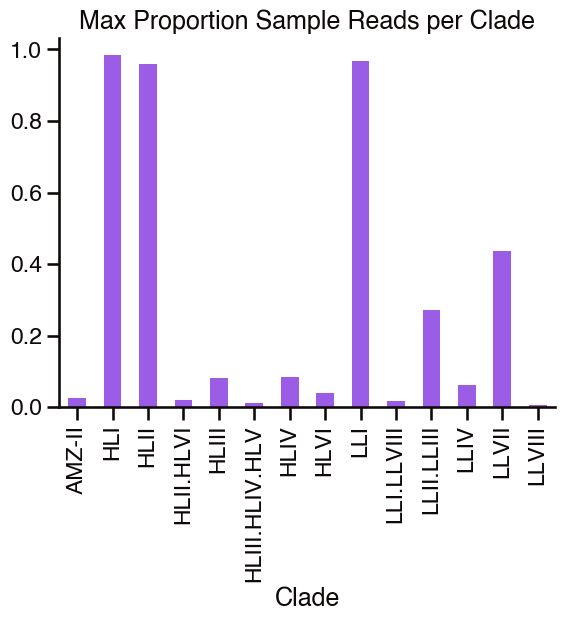

In [159]:
# get Pro community composition data together

pro_comp_df = comp_df[comp_df['Group'] == 'Prochlorococcus']
pro_comp_df = pro_comp_df.groupby(['samplename', 'Clade'])['CladeProportionReads'].mean().reset_index()
max_reads = pro_comp_df.groupby('Clade').CladeProportionReads.max()
print(max_reads)
max_reads.plot(kind='bar', title='Max Proportion Sample Reads per Clade')

# replace low abundance clades with "other" label
others = ['AMZ-II', 'HLII.HLVI', 'HLIII.HLIV.HLV', 'HLVI', 'LLI.LLVIII', 'LLVIII']
pro_comp_df.loc[pro_comp_df['Clade'].isin(others), 'Clade'] = 'Other'
pro_comp_df = pro_comp_df.groupby(['samplename', 'Clade'])['CladeProportionReads'].sum().reset_index()
max_other = pro_comp_df.loc[pro_comp_df[pro_comp_df.Clade == 'Other'].CladeProportionReads.idxmax(), :]
print(f"\nClades combined as 'Other': {others}")
print(f"Max proportion 'Other' reads: {max_other['CladeProportionReads']*100:.2f}% in sample {max_other['samplename']}\n")

# add back sample metadata
pro_comp_df = pd.merge(pro_comp_df, sample_df, on='samplename', how='left')

# # plot data
# for dataset in comp_df['samplegroup'].unique():
#     # get data together
#     plot_df = pro_comp_df[(pro_comp_df['samplegroup'] == dataset)]
    
#     axis = plot_df.pivot(index='samplename', columns='Clade', values='CladeProportionReads').plot(
#         kind='bar', stacked=True, color=[sns.color_palette()[i] for i in [1, 2, 3, 0, 5, 6, 7, 8, 4]]
#     ) 
#     axis.legend(loc='center left', bbox_to_anchor=(1, 0.5)); 
#     plt.show()


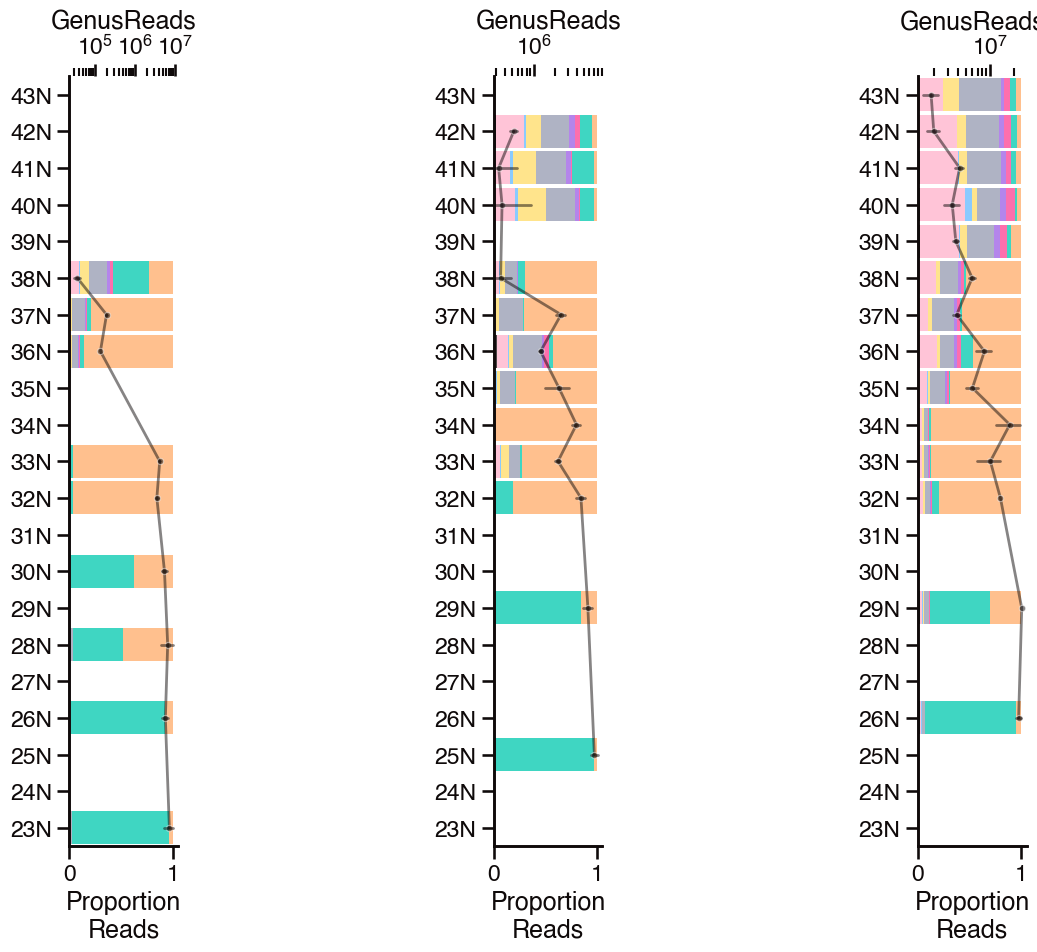

In [273]:
# Plot Prochlorococcus commmunity abundances

# set up figure
fig = plt.figure(figsize=(16, 10))
rows = 1
cols = 9
grid = plt.GridSpec(rows, cols, wspace=.3)
n_bins = 21
bounds = (23, 43)
color_palette = [sns.color_palette()[i] for i in [1, 2, 3, 0, 5, 6, 7, 8, 4]]

# plot Pro community composition data
for i, year in enumerate([2016, 2017, 2019]):
    # plot community composition
    axis = plt.subplot(grid[0, 3*i:3*i+1])
    plot_df = pro_comp_df[(pro_comp_df['year'] == year) & (pro_comp_df['samplegroup'] == 'surface transect')]
    latitudes = plot_df[
        ['samplename', 'latitude']].drop_duplicates().set_index('samplename').sort_values('latitude')['latitude']
    lat_bins = unique_bins(latitudes, n_bins, bounds=bounds, reverse=False)
    plot_df['lat_idx'] = plot_df['samplename'].map(dict(zip(latitudes.index, lat_bins)))
    sns.histplot(
        data=plot_df, y='lat_idx', hue='Clade', weights='CladeProportionReads', multiple='stack', 
        palette=color_palette, bins=n_bins, binrange=(0, n_bins), legend=False, shrink=0.9, ax=axis
    )
    axis.set(ylabel='', xlabel='Proportion\nReads', ylim=(0, n_bins))
    axis.set_yticks(np.arange(n_bins)+0.5, [f'{int(l)}N' for l in np.linspace(bounds[0], bounds[1], num=n_bins)])
    
    # plot overall Pro/Syn abundance
    # axis = plt.subplot(grid[0, 3*i+1:3*i+2])
    # # add title
    # if i == 1:
    #     axis.annotate('surface transects', xy=(.5, 1.07), xycoords='axes fraction', va='center', ha='center', fontsize=20)
    plot_df = pro_abun_df[(pro_abun_df['year'] == year) & (pro_abun_df['samplegroup'] == 'surface transect')]
    # sns.lineplot(
    #     data=plot_df, x='GenusReads', y='latitude', color=sns.color_palette()[4], 
    #     estimator='mean', errorbar='sd', err_style='bars', orient='y', legend=False, ax=axis
    # )
    # axis.set(ylim=(bounds[0]-0.5, bounds[1]+0.5), ylabel='', xlabel='Total Reads\n(x1e6)', title=year)
    # axis.tick_params(left=True, labelleft=False)
    # # axis.ticklabel_format(axis='x', style='plain')
    plot_df['lat_idx'] = plot_df['samplename'].map(dict(zip(latitudes.index, lat_bins+0.5)))
    axis2 = plt.twiny(axis)
    sns.lineplot(
        plot_df, x='GenusReads', y='lat_idx', estimator='mean', errorbar='sd', err_style='bars', orient='y', 
        color=sns.color_palette()[4], alpha=0.5, marker='.'
    )
    axis2.set(xscale='log')
    

In [264]:
lat_bins

array([ 3,  6,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [248]:
lat_bins

array([ 3,  6,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [238]:
axis.get_xticklabels()

[Text(-25000000.0, 0, '−2.5'),
 Text(0.0, 0, '0.0'),
 Text(25000000.0, 0, '2.5'),
 Text(50000000.0, 0, '5.0')]

Clade
5.1A-CRD2            0.375010
5.1A-II              0.788908
5.1A-III             0.174987
5.1A-IV              0.882623
5.1A-UC-A-EnvC       0.199863
5.1A-WPC1            0.055136
5.1A-unclassified    0.298398
5.1B-CRD1            0.742577
5.1B-I               0.462903
5.1B-IX              0.128143
5.1B-V               0.004551
5.1B-VI              0.009515
5.1B-VIII            0.022010
5.2                  0.479231
5.3                  0.435255
Unclassified         0.013092
Name: CladeProportionReads, dtype: float64

Clades combined as 'Other': ['5.1A-WPC1', '5.1B-V', '5.1B-VI', '5.1B-VIII', 'Unclassified']
Max proportion 'Other' reads: 6.24% in sample G3.UW.NS.UW29_1.7m



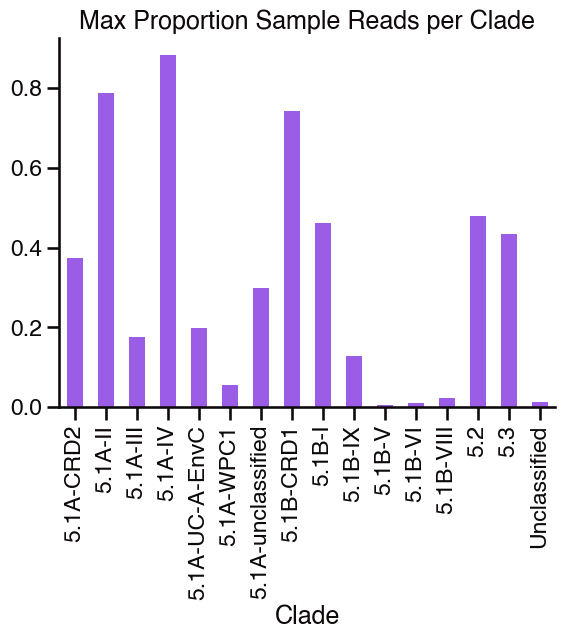

In [158]:
# get Pro community composition data together

syn_comp_df = comp_df[comp_df['Group'] == 'Synechococcus']
syn_comp_df = syn_comp_df.groupby(['samplename', 'Clade'])['CladeProportionReads'].mean().reset_index()
max_reads = syn_comp_df.groupby('Clade').CladeProportionReads.max()
print(max_reads)
max_reads.plot(kind='bar', title='Max Proportion Sample Reads per Clade')

# replace low abundance clades with "other" label
others = ['5.1A-WPC1', '5.1B-V', '5.1B-VI', '5.1B-VIII', 'Unclassified']
syn_comp_df.loc[syn_comp_df['Clade'].isin(others), 'Clade'] = 'Other'
syn_comp_df = syn_comp_df.groupby(['samplename', 'Clade'])['CladeProportionReads'].sum().reset_index()
max_other = syn_comp_df.loc[syn_comp_df[syn_comp_df.Clade == 'Other'].CladeProportionReads.idxmax(), :]
print(f"\nClades combined as 'Other': {others}")
print(f"Max proportion 'Other' reads: {max_other['CladeProportionReads']*100:.2f}% in sample {max_other['samplename']}\n")

# add back sample metadata
syn_comp_df = pd.merge(syn_comp_df, sample_df, on='samplename', how='left')

# # set color palette
# colors = [sns.color_palette()[i] for i in [0, 1, 2, 3, 6, 5, 7, 8]] + \
#     [sns.color_palette('hls', 6)[i] for i in [4, 2, 0]] + [sns.color_palette()[4]]

# # plot data
# for dataset in comp_df['samplegroup'].unique():
#     # get data together
#     plot_df = data_df[(data_df['samplegroup'] == dataset)]
    
#     axis = plot_df.pivot(index='samplename', columns='Clade', values='CladeProportionReads').plot(
#         kind='bar', stacked=True, color=colors
#     ) 
#     axis.legend(loc='center left', bbox_to_anchor=(1, 0.5)); 
#     plt.show()
    

In [ ]:
# plot surface clade abundances

# set up figure
sample_weight_range = (-0.05, 0.65) # range of weights to show on sample plots
fig = plt.figure(figsize=(16, 10))
rows = 1
cols = 21
grid = plt.GridSpec(rows, cols, wspace=.3)
n_bins = 21
bounds = (23, 43)

# plot Pro & Syn community composition data
for i, year in enumerate([2016, 2017, 2019]):
    genus = 'Prochlorococcus'
    axis = plt.subplot(grid[0, 7*i:7*i+2])
    # get data together
    plot_df = comp_df[comp_df['Group'] == genus]
    plot_df = plot_df[(plot_df['year'] == year) & (plot_df['samplegroup'] == 'surface transect')]
    plot_df = plot_df.groupby(['samplename', 'latitude'])['CladeProportionReads'].mean().reset_index()
    latitudes = plot_df[
        ['samplename', 'latitude']].drop_duplicates().set_index('samplename').sort_values('latitude')['latitude']
    lat_bins = unique_bins(latitudes, n_bins, bounds=bounds, reverse=True)
    plot_df['lat_idx'] = plot_df['samplename'].map(dict(zip(latitudes.index, lat_bins)))
    # make figure
    sns.barplot(
        data=plot_df, x='sampleweights', y='lat_idx', hue='genus', hue_order=['Prochlorococcus', 'Synechococcus'], 
        palette=[sns.color_palette()[i] for i in [2, 3]], 
        orient='h', order=np.arange(n_bins), fill=False, whis=(5, 95), fliersize=3, legend=False, ax=axis
    )
    # set labels and such
    axis.set(xlim=sample_weight_range, ylabel='', xlabel='Fe cluster\nweights',)
    axis.set_yticks(np.arange(n_bins), [f'{int(l)}N' for l in np.linspace(bounds[1], bounds[0], num=n_bins)])
    
    # N acquisition cluster
    axis = plt.subplot(grid[0, 7*i+2:7*i+4])
    # add title
    if i == 1:
        axis.annotate('surface transects', xy=(.5, 1.07), xycoords='axes fraction', 
                      va='center', ha='center', fontsize=20)
    # get data together
    plot_df = n_cluster_df[n_cluster_df['samplegroup'] == 'surface transect']
    plot_df = plot_df[plot_df['year'] == year]
    plot_df['lat_idx'] = plot_df['samplename'].map(dict(zip(latitudes.index, lat_bins)))
    # make figure
    sns.boxplot(
        data=plot_df, x='sampleweights', y='lat_idx', hue='genus', hue_order=['Prochlorococcus', 'Synechococcus'], 
        palette=[sns.color_palette()[i] for i in [2, 3]], 
        orient='h', order=np.arange(n_bins), fill=False, whis=(5, 95), fliersize=3, legend=False, ax=axis
    )
    # set labels and such
    axis.set(xlim=sample_weight_range, ylabel='', xlabel='N cluster\nweights', title=year)
    axis.tick_params(left=True, labelleft=False)

# plot environmental covariates
for i, year in enumerate([2016, 2017, 2019]):
    axis = plt.subplot(grid[0, 7*i+4:7*i+6])
    # plot salinity front
    axis.hlines(y=sal_fronts[year], 
                xmin=0, xmax=2, linewidth=10, color=sns.color_palette()[5], alpha=0.2)
    # plot chlorophyll front
    axis.hlines(y=chl_fronts[year], 
                xmin=0, xmax=2, linewidth=10, color=sns.color_palette()[2], alpha=0.2)
    
    # dissolved iron
    color = sns.color_palette()[1]
    sns.lineplot(
        data=fe_df[(fe_df['year'] == year) & (fe_df['depth'].le(15))], 
        x='Fe_dissolved', y='lat', orient='y', ax=axis, color=color, marker='.'
    )
    axis.set(xlim=(-.05, 0.85), ylim=(bounds[0]-0.5, bounds[1]+.5), yticks=np.linspace(bounds[0], bounds[1], n_bins), 
             xlabel='[Fe]', ylabel='')
    axis.tick_params(left=True, labelleft=False)
    axis.tick_params(axis='x', colors=color)
    axis.xaxis.label.set_color(color)
    axis.spines['bottom'].set_color(color)

    # dissolved nitrate + nitrite
    color = sns.color_palette()[7]
    axis2 = plt.twiny(axis)
    sns.lineplot(
        data=n_diss_df[(n_diss_df['year'] == year) & (n_diss_df['depth'].le(15))], 
        x='NO3_NO2', y='lat', orient='y', ax=axis2, color=color, marker='.'
    )
    axis2.set(xlim=(-0.5, 7.5), ylim=(bounds[0]-0.5, bounds[1]+.5), yticks=np.linspace(bounds[0], bounds[1], n_bins), 
             xlabel='[NO3+NO2]', ylabel='')
    axis2.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    axis2.tick_params(axis='x', colors=color)
    axis2.xaxis.set_label_position('bottom')
    axis2.xaxis.label.set_color(color)
    axis2.spines['bottom'].set_color(color)
    axis2.spines['bottom'].set_position(('outward', 60))

    # N:Fe ratio
    color = sns.color_palette()[4]
    axis3 = plt.twiny(axis2)
    sns.lineplot(
        data=merged_df[(merged_df['year'] == year) & (merged_df['depth'].le(15))], 
        x='N:Fe', y='lat', orient='y', ax=axis3, color=color, marker='.'
    )
    axis3.set(xlim=(0.001, 1000), ylim=(bounds[0]-0.5, bounds[1]+.5), yticks=np.linspace(bounds[0], bounds[1], n_bins), 
             xlabel='[N]:[Fe]', ylabel='', xscale='log')
    axis3.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    axis3.tick_params(axis='x', colors=color)
    axis3.xaxis.set_label_position('bottom')
    axis3.xaxis.label.set_color(color)
    axis3.spines['bottom'].set_color(color)
    axis3.spines['bottom'].set_position(('outward', 120))

# render image
fig.savefig('surface-clade-abundances.png', bbox_inches='tight')
